# Problem Set 9 - Interpretability

## Problem 0
**(-2 points for every missing green OK sign. If you don't run the cell below, that's -14 points.)**

Make sure you are in the DATA1030 environment.

In [13]:
from __future__ import print_function
from packaging.version import parse as Version
from platform import python_version

OK = '\x1b[42m[ OK ]\x1b[0m'
FAIL = "\x1b[41m[FAIL]\x1b[0m"

try:
    import importlib
except ImportError:
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % sys.version)

def import_version(pkg, min_ver, fail_msg=""):
    mod = None
    try:
        mod = importlib.import_module(pkg)
        if pkg in {'PIL'}:
            ver = mod.VERSION
        else:
            ver = mod.__version__
        if Version(ver) == Version(min_ver):
            print(OK, "%s version %s is installed."
                  % (lib, min_ver))
        else:
            print(FAIL, "%s version %s is required, but %s installed."
                  % (lib, min_ver, ver))    
    except ImportError:
        print(FAIL, '%s not installed. %s' % (pkg, fail_msg))
    return mod


# first check the python version
pyversion = Version(python_version())

if pyversion >= Version("3.11.4"):
    print(OK, "Python version is %s" % pyversion)
elif pyversion < Version("3.11"):
    print(FAIL, "Python version 3.11 is required,"
                " but %s is installed." % pyversion)
else:
    print(FAIL, "Unknown Python version: %s" % pyversion)

    
print()
requirements = {'numpy': "1.24.4", 'matplotlib': "3.7.2",'sklearn': "1.3.0", 
                'pandas': "2.0.3",'xgboost': "1.7.6", 'shap': "0.42.1", 'seaborn': "0.12.2"}

# now the dependencies
for lib, required_version in list(requirements.items()):
    import_version(lib, required_version)

[ OK ] Python version is 3.11.4

[ OK ] numpy version 1.24.4 is installed.
[ OK ] matplotlib version 3.7.2 is installed.
[ OK ] sklearn version 1.3.0 is installed.
[ OK ] pandas version 2.0.3 is installed.
[ OK ] xgboost version 1.7.6 is installed.
[ OK ] shap version 0.42.1 is installed.
[ OK ] seaborn version 0.12.2 is installed.


## Description

In this problem set you will use the kaggle house price dataset to work through a couple of different feature importance metrics. We provide you with code that trains an XGBoost regression model. You should not need to edit any of the below code, but look through it to make sure you understand what's going on. 

The main take-away from this problem set is that feature importance is not easy to measure and it depends strongly on what metric you use. 

In [1]:
# read the data
import pandas as pd
import numpy  as np
from sklearn.model_selection import train_test_split

# Let's load the data
df = pd.read_csv('data/train.csv')
# drop the ID
df.drop(columns=['Id'],inplace=True)

# the target variable
y = df['SalePrice']
df.drop(columns=['SalePrice'],inplace=True)
# the unprocessed feature matrix
X = df.values
print(f'feature matrix size: {X.shape}')
# the feature names
ftrs = df.columns

feature matrix size: (1460, 79)


In [2]:
# let's split to train, CV, and test
X_other, X_test, y_other, y_test = train_test_split(df, y, test_size=0.2, random_state=0)
X_train, X_CV, y_train, y_CV = train_test_split(X_other, y_other, test_size=0.25, random_state=0)

print(f'train size: {X_train.shape}')
print(f'validation size: {X_CV.shape}')
print(f'test size: {X_test.shape}')

train size: (876, 79)
validation size: (292, 79)
test size: (292, 79)


In [3]:
# collect the various features
cat_ftrs = ['MSZoning','Street','Alley','LandContour','LotConfig','Neighborhood','Condition1','Condition2',\
            'BldgType','HouseStyle','RoofStyle','RoofMatl','Exterior1st','Exterior2nd','MasVnrType','Foundation',\
           'Heating','CentralAir','Electrical','GarageType','PavedDrive','MiscFeature','SaleType','SaleCondition']
ordinal_ftrs = ['LotShape','Utilities','LandSlope','ExterQual','ExterCond','BsmtQual','BsmtCond','BsmtExposure',\
               'BsmtFinType1','BsmtFinType2','HeatingQC','KitchenQual','Functional','FireplaceQu','GarageFinish',\
               'GarageQual','GarageCond','PoolQC','Fence']
ordinal_cats = [['Reg','IR1','IR2','IR3'],['AllPub','NoSewr','NoSeWa','ELO'],['Gtl','Mod','Sev'],\
               ['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Po','Fa','TA','Gd','Ex'],['NA','No','Mn','Av','Gd'],['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],\
               ['NA','Unf','LwQ','Rec','BLQ','ALQ','GLQ'],['Po','Fa','TA','Gd','Ex'],['Po','Fa','TA','Gd','Ex'],\
               ['Sal','Sev','Maj2','Maj1','Mod','Min2','Min1','Typ'],['NA','Po','Fa','TA','Gd','Ex'],\
               ['NA','Unf','RFn','Fin'],['NA','Po','Fa','TA','Gd','Ex'],['NA','Po','Fa','TA','Gd','Ex'],
               ['NA','Fa','TA','Gd','Ex'],['NA','MnWw','GdWo','MnPrv','GdPrv']]
num_ftrs = ['MSSubClass','LotFrontage','LotArea','OverallQual','OverallCond','YearBuilt','YearRemodAdd',\
             'MasVnrArea','BsmtFinSF1','BsmtFinSF2','BsmtUnfSF','TotalBsmtSF','1stFlrSF','2ndFlrSF',\
             'LowQualFinSF','GrLivArea','BsmtFullBath','BsmtHalfBath','FullBath','HalfBath','BedroomAbvGr',\
             'KitchenAbvGr','TotRmsAbvGrd','Fireplaces','GarageYrBlt','GarageCars','GarageArea','WoodDeckSF',\
             'OpenPorchSF','EnclosedPorch','3SsnPorch','ScreenPorch','PoolArea','MiscVal','MoSold','YrSold']

In [4]:
# preprocess with pipeline and columntransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import OrdinalEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

# one-hot encoder
categorical_transformer = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant',fill_value='missing')),
    ('onehot', OneHotEncoder(sparse_output=False,handle_unknown='ignore'))])

# ordinal encoder
ordinal_transformer = Pipeline(steps=[
    ('imputer2', SimpleImputer(strategy='constant',fill_value='NA')),
    ('ordinal', OrdinalEncoder(categories = ordinal_cats))])

# standard scaler
numeric_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())])

# collect the transformers
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, num_ftrs),
        ('cat', categorical_transformer, cat_ftrs),
        ('ord', ordinal_transformer, ordinal_ftrs)])

In [5]:
# fit_transform the training set
X_prep = preprocessor.fit_transform(X_train)
# little hacky, but collect feature names
feature_names = preprocessor.get_feature_names_out()

df_train = pd.DataFrame(data=X_prep,columns=feature_names)
print(f'preprocessed train size: {df_train.shape}')

# transform the CV
df_CV = preprocessor.transform(X_CV)
df_CV = pd.DataFrame(data=df_CV,columns = feature_names)
print(f'preprocessed validation size: {df_CV.shape}')

# transform the test
df_test = preprocessor.transform(X_test)
df_test = pd.DataFrame(data=df_test,columns = feature_names)
print(f'preprocessed test size: {df_test.shape}')

preprocessed train size: (876, 220)
preprocessed validation size: (292, 220)
preprocessed test size: (292, 220)


In [6]:
# import necessary libraries for xgboost 
import xgboost
from sklearn.model_selection import ParameterGrid
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# parameters to try 
param_grid = {"learning_rate": [0.03],
              "n_estimators": [10000],
              "seed": [0],
              "missing": [np.nan], 
              "colsample_bytree": [0.9],              
              "subsample": [0.66]}

# create xgboost model and set parameters 
XGB = xgboost.XGBRegressor(early_stopping_rounds=50)
XGB.set_params(**ParameterGrid(param_grid)[0])

# fit model to train data 
XGB.fit(df_train,y_train,eval_set=[(df_CV, y_CV)], verbose=False)

# predict on validation 
y_CV_pred = XGB.predict(df_CV)
print('the CV RMSE:',np.sqrt(mean_squared_error(y_CV,y_CV_pred)))

# predict on test 
y_test_pred = XGB.predict(df_test)
print('the test RMSE:',np.sqrt(mean_squared_error(y_test,y_test_pred)))
print('the test R2:',r2_score(y_test,y_test_pred))

the CV RMSE: 23150.929568295433
the test RMSE: 33542.77824967617
the test R2: 0.8370775532958903


## Problem 1 (5 points)

Calculate the perturbation feature importance values on the test set and visualize the results. This dataset has many features so show only the top 10 most important ones on the figure. You can use the code from the lecture notes or work with sklearn's [permutation_importance](https://scikit-learn.org/stable/modules/generated/sklearn.inspection.permutation_importance.html).

In [7]:
# your code here
np.random.seed(42)

nr_runs = 10
ftr_names = df_test.columns
scores = np.zeros([len(ftr_names),nr_runs])
mean_scores = np.zeros(len(ftr_names))

test_score = XGB.score(df_test,y_test) # the test score of XGB is R2
print('test score = ',test_score)

# loop through the features
for i in range(len(ftr_names)):
    print('shuffling '+str(ftr_names[i]))
    R2_shuffled = []
    for j in range(nr_runs):
        df_test_shuffled = df_test.copy()
        df_test_shuffled[ftr_names[i]] = np.random.permutation(df_test[ftr_names[i]].values)
        R2_shuffled.append(XGB.score(df_test_shuffled,y_test))
    print('   shuffled test score:',np.around(np.mean(R2_shuffled),3),'+/-',np.around(np.std(R2_shuffled),3))
    mean_scores[i] = np.mean(R2_shuffled)
    scores[i] = R2_shuffled

test score =  0.8370775532958903
shuffling num__MSSubClass


   shuffled test score: 0.837 +/- 0.001
shuffling num__LotFrontage
   shuffled test score: 0.852 +/- 0.006
shuffling num__LotArea
   shuffled test score: 0.822 +/- 0.003
shuffling num__OverallQual
   shuffled test score: 0.677 +/- 0.015
shuffling num__OverallCond
   shuffled test score: 0.832 +/- 0.001
shuffling num__YearBuilt
   shuffled test score: 0.832 +/- 0.001
shuffling num__YearRemodAdd
   shuffled test score: 0.831 +/- 0.003
shuffling num__MasVnrArea
   shuffled test score: 0.837 +/- 0.0
shuffling num__BsmtFinSF1
   shuffled test score: 0.825 +/- 0.002
shuffling num__BsmtFinSF2
   shuffled test score: 0.836 +/- 0.001
shuffling num__BsmtUnfSF
   shuffled test score: 0.832 +/- 0.002
shuffling num__TotalBsmtSF
   shuffled test score: 0.811 +/- 0.003
shuffling num__1stFlrSF
   shuffled test score: 0.813 +/- 0.004
shuffling num__2ndFlrSF
   shuffled test score: 0.835 +/- 0.001
shuffling num__LowQualFinSF
   shuffled test score: 0.837 +/- 0.0
shuffling num__GrLivArea
   shuffled test

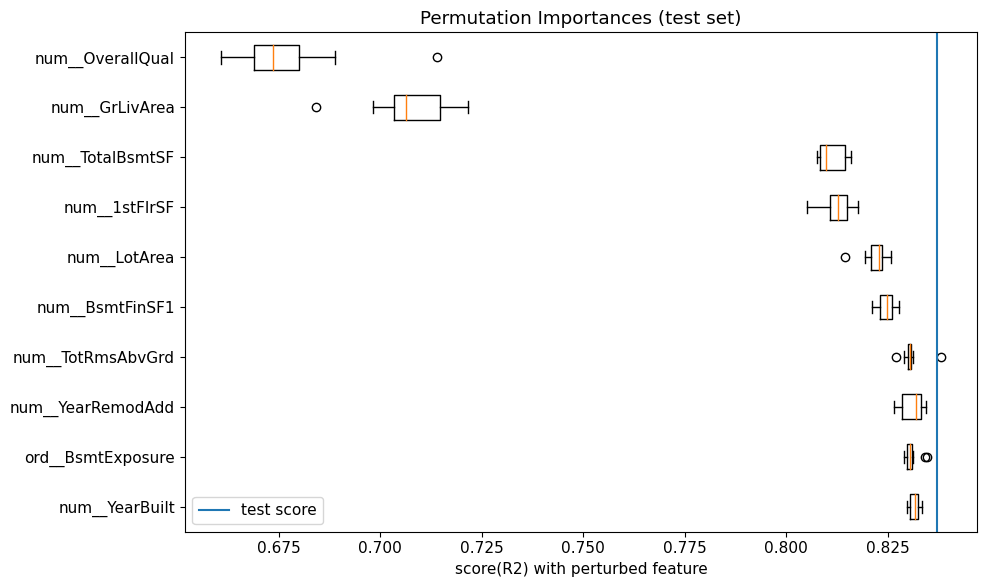

In [8]:
import matplotlib.pylab as plt
sorted_indcs = np.argsort(mean_scores)[:10][::-1]
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(10,6))
plt.boxplot(scores[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.axvline(test_score,label='test score')
plt.title("Permutation Importances (test set)")
plt.xlabel('score(R2) with perturbed feature')
plt.legend()
plt.tight_layout()
plt.show()

                   Importance score
num__YearBuilt             0.160125
ord__BsmtQual              0.132480
num__YearRemodAdd          0.026640
num__TotRmsAbvGrd          0.026015
num__BsmtFinSF1            0.016698
num__LotArea               0.012110
num__1stFlrSF              0.007479
num__TotalBsmtSF           0.006995
num__GrLivArea             0.005723
num__OverallQual           0.005172


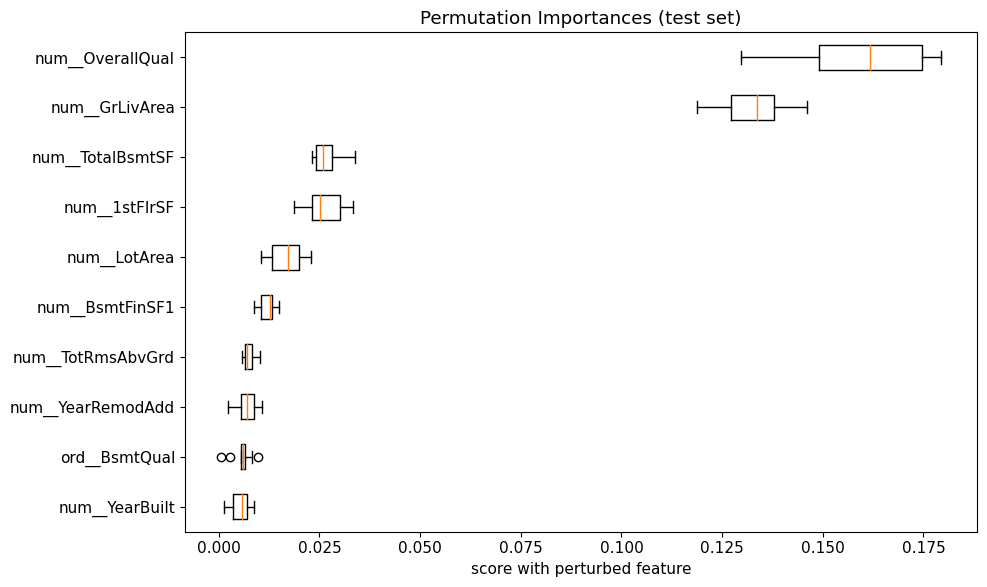

In [9]:
from sklearn.inspection import permutation_importance
import matplotlib.pylab as plt

#(1) Calculate the feature importance
result = permutation_importance(XGB, df_test, y_test, scoring='r2', n_repeats=10, random_state=42)
sorted_indcs = np.argsort(result.importances_mean)[-10:]
top10_ftr_importance = pd.DataFrame(data=result.importances_mean[sorted_indcs][::-1],index=ftr_names[sorted_indcs],columns=['Importance score'])
print(top10_ftr_importance)

# (2) Plot out the top 10 important feature
plt.rcParams.update({'font.size': 11})
plt.figure(figsize=(10,6))
plt.boxplot(result.importances[sorted_indcs].T,labels=ftr_names[sorted_indcs],vert=False)
plt.title("Permutation Importances (test set)")
plt.xlabel('score with perturbed feature')
plt.tight_layout()
plt.show()

## Problem 2 (10 points)

As we discussed in class, XGBoost implements 5 different metrics to measure feature importance. Calculate all 5 metrics and create 5 figures showing the top 10 most important features for each metric.

Importance_types = weight:


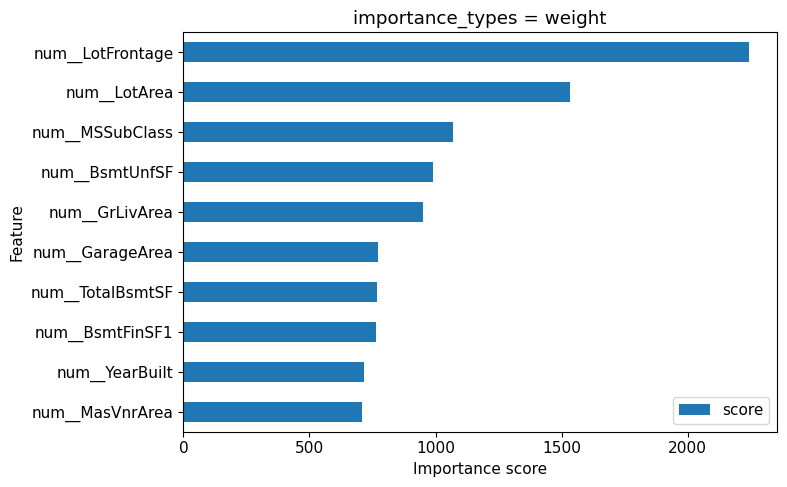

Importance_types = gain:


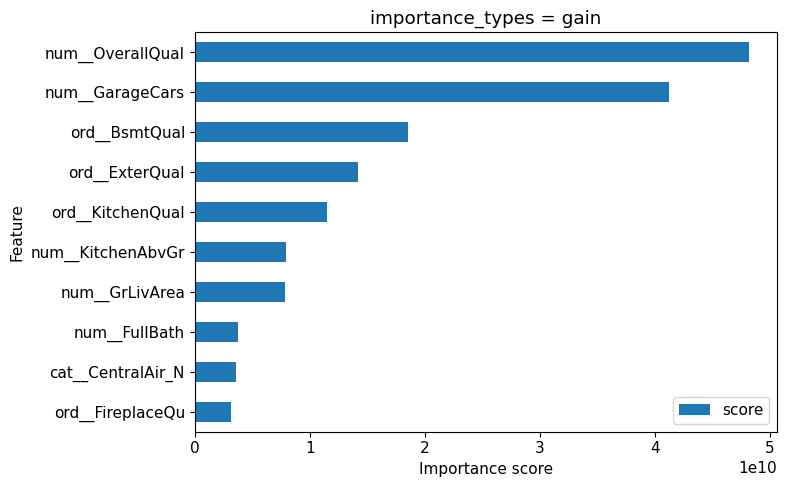

Importance_types = cover:


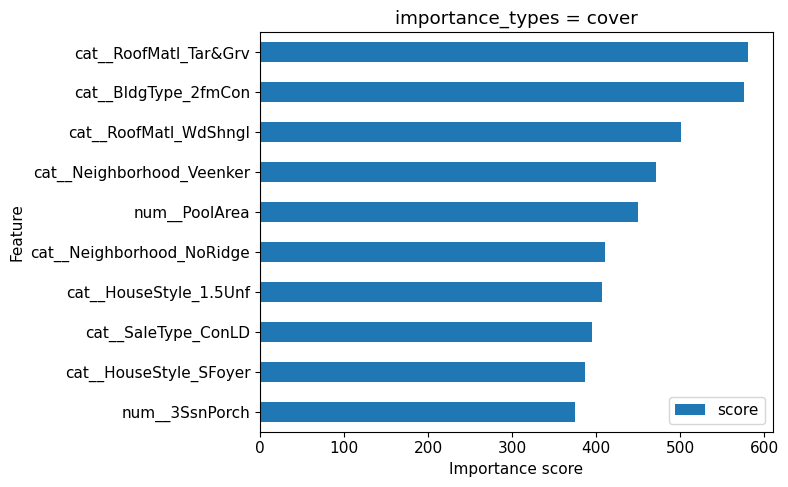

Importance_types = total_gain:


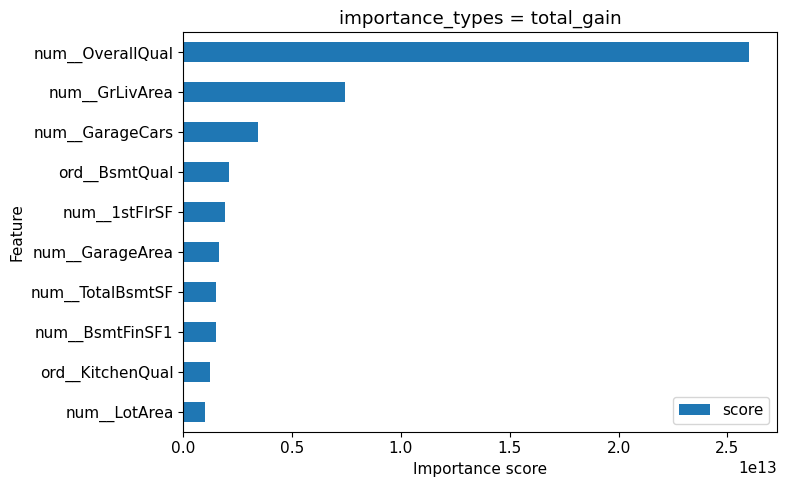

Importance_types = total_cover:


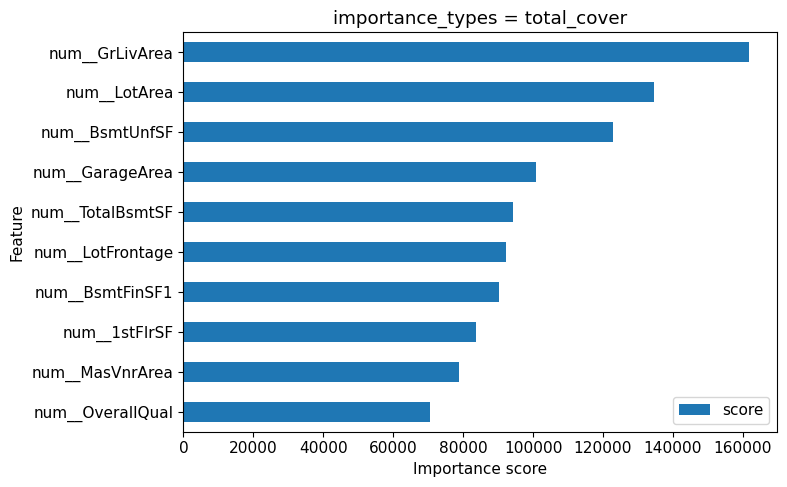

In [10]:
importance_types = ['weight', 'gain', 'cover', 'total_gain', 'total_cover']
for type in range(len(importance_types)):
    feature_importance = XGB.get_booster().get_score(importance_type = importance_types[type])
    keys = list(feature_importance.keys())
    values = list(feature_importance.values())
    importance_score = pd.DataFrame(data=values, index=keys, columns=["score"]).sort_values(by = "score", ascending=False)

    print('Importance_types = '+importance_types[type]+':')
    importance_score[:10][::-1].plot.barh(figsize=(8,5))
    plt.xlabel('Importance score')
    plt.ylabel('Feature')
    plt.title('importance_types = %s'%(importance_types[type]))
    plt.tight_layout()
    plt.show()

## Problem 3a (10 points)

Let's now calculate the shap values of the test set points. Use the shap values to calculate global feature importance values and prepare a plot that shows the top 10 most important features. Choose one of the two approaches:

1) You can use the shap package as we did in class. You will encounter an error which you'll need to solve yourself. Please do not ask about this error on Ed Discussion. Instead, figure it out yourself. You'll also need to manually change some parameters of the plot.

2) XGBoost can directly calculate shap values for you (look up how) but you need to recreate the figures with matplotlib because XGBoost's shap values don't come with visualizations. 

Both approaches take roughly the same amount of time to work through. 

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


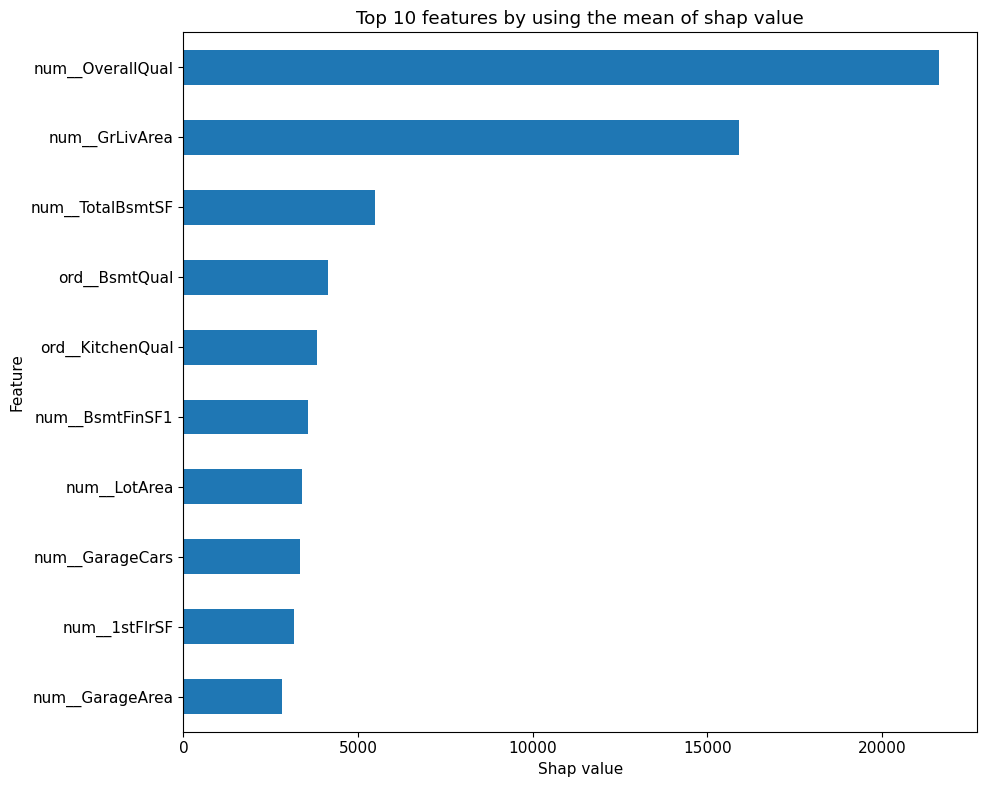

In [11]:
# your code here

import shap
shap.initjs()
explainer = shap.TreeExplainer(XGB)
shap_values = explainer.shap_values(df_test)
shap_values = pd.DataFrame(data=shap_values,columns=ftr_names)
shap_mean = np.mean(np.abs(shap_values),axis=0)
top10_shap_idx = np.argsort(shap_mean)[-10:][::-1]
top10_shap_values = shap_mean[top10_shap_idx]
plt.figure(figsize=(10,8))
top10_shap_values[::-1].plot.barh()
plt.xlabel('Shap value')
plt.ylabel('Feature')
plt.title('Top 10 features by using the mean of shap value')
plt.tight_layout()
plt.show()

No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


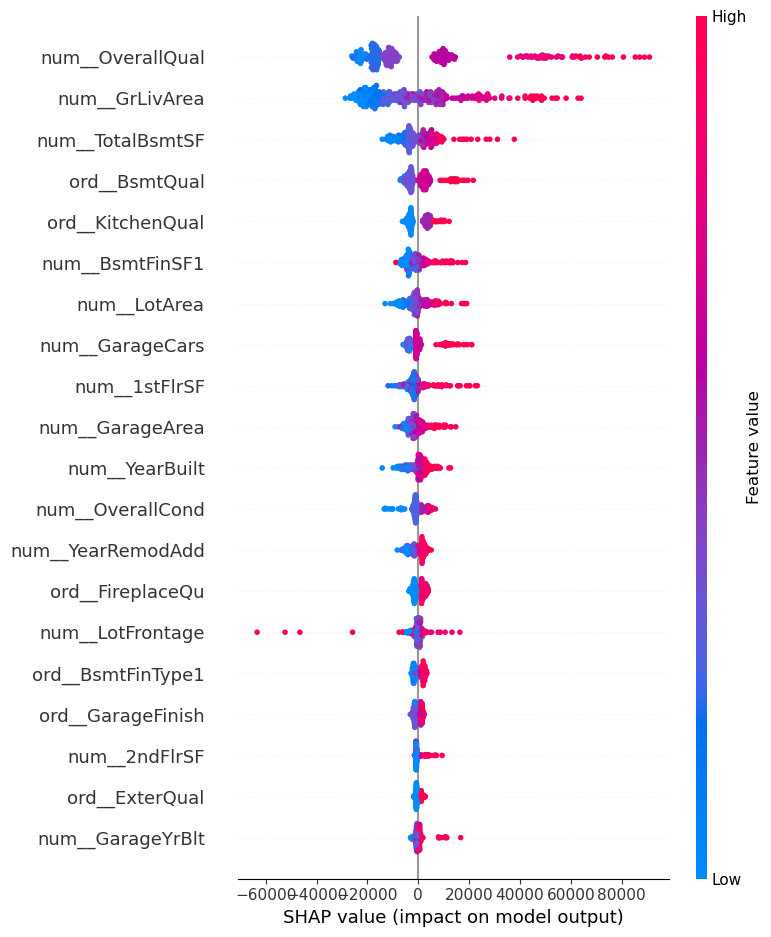

In [12]:
import shap
shap.initjs()
explainer = shap.TreeExplainer(XGB.get_booster())
shap_value = explainer.shap_values(df_test)
shap.summary_plot(shap_value, df_test,feature_names = feature_names)

## Problem 3b (10 points)

Let's take a look at some specific data points with indices 0, 100, and 200. For each data point, create a force plot and describe in a paragraph or two which features contribute positively and negatively to the prediction.

index =  0
181170.16


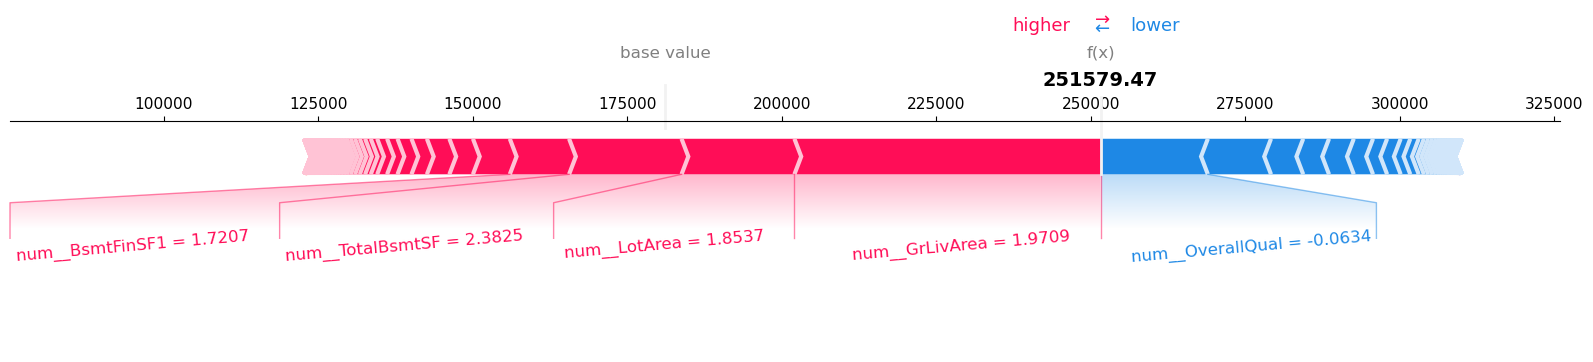

index =  100
181170.16


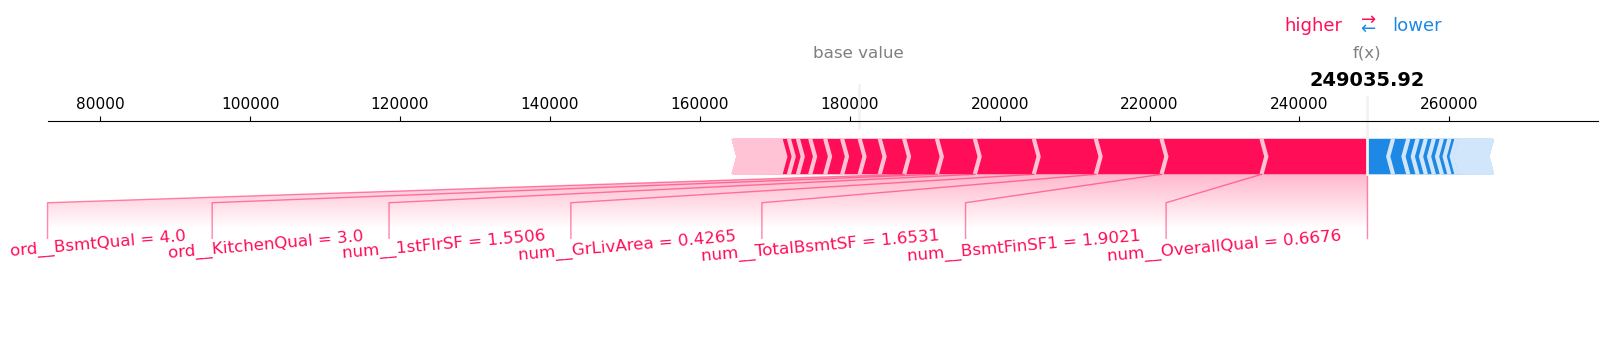

index =  200
181170.16


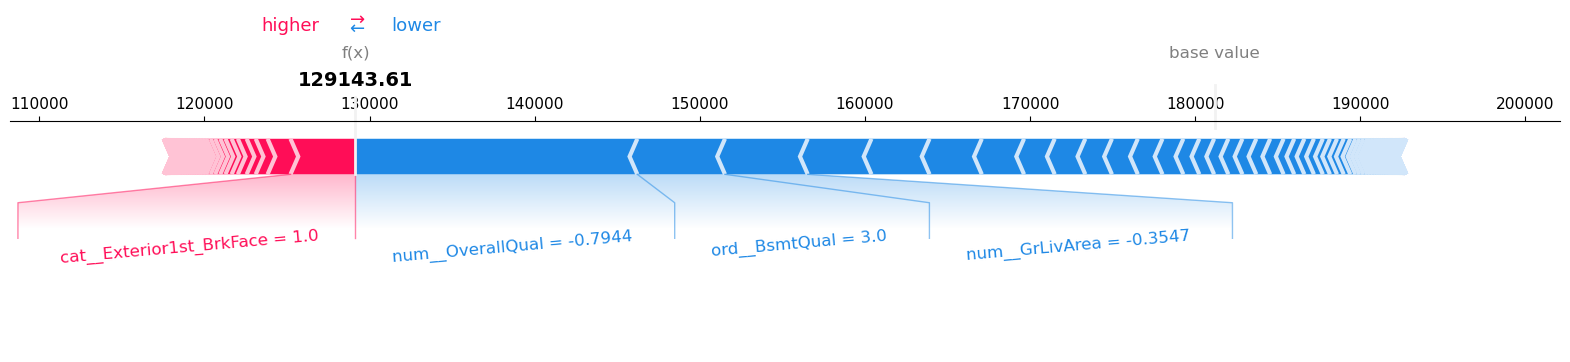

In [13]:
# your code here

index = [0,100,200] # the index of the point to explain
for i in index:
    print('index = ',i)
    print(explainer.expected_value) # the baseline value
    shap.force_plot(explainer.expected_value, shap_values.loc[i,:].values, features = np.around(df_test.loc[i,:].values,4),feature_names = feature_names,matplotlib=True,figsize=(20,3),text_rotation=5)

**your explanation here**

For the force plot of each datapoint, the length of the arrow of each feature indicates how much contribution this feature provides to its expected value. The longer the arrow is, the more or stronger this feature contributes to.

For instance, for the datapoint with index = 0, the feature 'num_GrLivArea' has the most positive contribution to push the shap value from the base value 181170.16 to the expected value 251579.47 while 'num_OvellQual' has the most negative contribution to pull down the shap value. 

In addition, for the datapoint with index = 100, the feature 'num_OvellQual' contributes the most to the expected value positively, and then the feature 'num_BsmtFinSF1' and the feature 'num_TotalBsmtSF'.

Last but not least, for the datapoint with index = 200, the feature 'num_OverallQual' has the most negative contribution to pull down the shap value from the base value 181170.16 to the expected value 129143.61 and the feature 'ord_BsmtQual' is the feature that contributes second most to the shap value negatively. In contrast, the feature 'cat_Exterior1st_BrkFace' contributes most in a positive way.

## Problem 4 (5 points)

You calculated 7 different global feature importance metrics (perturbation, 5 XGB metrics, global shap). Unfortunately the ranking of features can be quite different depending on the importance metric used. Write a short discussion on the similarities and differences amongst the 7 methods. Are there features that tend to be in the top 3-5 regardless of the approach used? Discuss the pros and cons of the various approaches!

**your explanation here**

Among these seven methods, they are all model-agnostic, which means they can be applied to various machine learning models. This similarity provides multiple choices of feature importance and a more general understanding of feature importance. Also, if one of the methods could not help us interpret our model results well, we could still change to use another mothod. And it is because of it, the difference among these 7 methods is that some metrics may be more interpretable than others. For instance, 'weight' in XGBoost is relatively easy to understand, as it directly reflects the frequency of a feature's use in the model. On the other hand, SHAP values provide a nuanced understanding of each feature's contribution to individual predictions but can be more challenging to interpret globally. In addtion, the most different thing among these 7 methods is that each metric has a unique way of quantifying feature importance. For example, 'weight' in XGBoost considers the number of times a feature appears in trees, while 'gain' considers the average gain of a feature when used in trees. These differences can lead to divergent rankings.

From the result of those 7 methods, wdd could figure out that thhe features 'num_OverallQual', 'num_GrLivArea', 'num_TotalBsmtSF' are the common three important features by using different feature importance method.

By using perturbation, the good thing is it is simple to implement,but it may not capture non-linear relationships well and it is also sensitive to feature scaling. Additionally, the advantage of using XGBoost metrics is that it is inherent to the XGBoost model and it is also easy to compute. However, it may be biased towards features with high cardinality and it is sensitive to hyperparameters. For the method of using SHAP values, it is good for us to captures complex interactions while it is computationally expensive and it can be hard to interpret globally.
